# Biostat M280 Homework 3

**Due Friday, May 25 @ 11:59PM**

## Q1 - Big $n$ regression

Those who took my _203B: Introduction to Data Science_ last quarter had a (painful) experience of wrangling an Apache Spark cluster to do linear regression on a dataset with more than 100 million observations. Now we learnt various methods for solving linear regression and should realize that, with right choice of algorithm, it is a problem that can be handled by any moderate computer.

### Q1(1)

Download the flight data from <http://stat-computing.org/dataexpo/2009/the-data.html>. For this exercise, we only need data from years 2003-2008. If you are using Mac or Linux, you can run the following Bash script, which downloads and unzips files for all years.
```bash
# Download flight data by year
for i in {1987..2008}
  do
    echo "$(date) $i Download"
    fnam=$i.csv.bz2
    wget -O ./$fnam http://stat-computing.org/dataexpo/2009/$fnam
    echo "$(date) $i unzip"
    bzip2 -d ./$fnam
  done

# Download airline carrier data
wget -O ./airlines.csv http://www.transtats.bts.gov/Download_Lookup.asp?Lookup=L_UNIQUE_CARRIERS

# Download airports data
wget -O ./airports.csv https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat
```
Find out how many data points in each year.

In [6]:
@show c2003 = countlines("2003.csv")
@show c2004 = countlines("2004.csv")
@show c2005 = countlines("2005.csv")
@show c2006 = countlines("2006.csv")
@show c2007 = countlines("2007.csv")
@show c2008 = countlines("2008.csv")
@show total_lines = c2003 + c2004 + c2005 + c2006 + c2007 + c2008

c2003 = countlines("2003.csv") = 6488541
c2004 = countlines("2004.csv") = 7129271
c2005 = countlines("2005.csv") = 7140597
c2006 = countlines("2006.csv") = 7141923
c2007 = countlines("2007.csv") = 7453216
c2008 = countlines("2008.csv") = 7009729
total_lines = c2003 + c2004 + c2005 + c2006 + c2007 + c2008 = 42363277


42363277

### Q1(2) 

We are interested in how the time gain of a flight, defined as `DepDelay - ArrDelay`, depends on the distance traveled (`Distance`), departure delay (`DepDelay`), and carrier (`UniqueCarrier`). 

We want to fit a linear regression `Gain ~ 1 + Distance + DepDelay + UniqueCarrier` using data from 2003-2008. Note `UniqueCarrier` is a factor with 23 levels: "9E", "AA", "AQ", "AS", "B6", "CO", "DH", "DL", "EV", "F9", "FL", "HA", "HP", "MQ", "NW", "OH", "OO", "TZ", "UA", "US", "WN", "XE", and "YV". We use the dummy coding with "9E" as base level.

Will the design matrix (in double precision) fit into the memory of you computer?

**(2)** Data from 2003-2008 contain 42363277 observations. The design matrix has dimension $42363277 \times 26$, so in total $42363277 \times 26$ of double-precision numbers. Every double-precision number is 8 bytes. We need a memory of $42363277 \times 26 \times 8 / 10^9 \sim $8.81GB to fit the whole matrix. My poor MacBook with a 8GB memory can not handle it.

### Q1(3)

Review the [Summary of Linear Regression](http://hua-zhou.github.io/teaching/biostatm280-2018spring/slides/12-linreg/linreg.html) and devise a strategy to solve the linear regression.

Report the estimated regression coefficients $\widehat \beta$, estimated variance $\widehat \sigma^2 = \sum_i (y_i - \widehat y_i)^2 / (n - 1)$, and coefficient standard errors.

Hint: It took my laptop less than 3 minutes to import data and fit linear regression.

In [145]:
# mapping from variable names to X columns
# carrier "9E" is used as base level
const var2col = Dict(
        "Intercept" => 1,
        "Distance" => 2,
        "DepDelay" => 3,
        "AA" => 4,
        "AQ" => 5,
        "AS" => 6,
        "B6" => 7,
        "CO" => 8,
        "DH" => 9,
        "DL" => 10,
        "EV" => 11,
        "F9" => 12,
        "FL" => 13,
        "HA" => 14,
        "HP" => 15,
        "MQ" => 16,
        "NW" => 17,
        "OH" => 18,
        "OO" => 19,
        "TZ" => 20,
        "UA" => 21,
        "US" => 22,
        "WN" => 23,
        "XE" => 24,
        "YV" => 25,
        "Gain" => 26)
# mapping from column to variable names
const col2var = map(reverse, var2col)

# a custom function to generate [X y] from data table
function generate_xy(tbl::NextTable)
    # X matrix
    XY = zeros(length(tbl), 26)
    # intercept term
    @views fill!(XY[:, 1], 1)
    # Distance term
    @views copy!(XY[:, 2], columns(tbl, :Distance))
    # DepDelay term
    @views copy!(XY[:, 3], columns(tbl, :DepDelay))
    # Dummy coding for airline
    @inbounds for i in 1:length(tbl)
        tbl[i][:UniqueCarrier] == "9E" && continue # base level
        XY[i, var2col[tbl[i][:UniqueCarrier]]] = 1
    end
    # last column is response: gain = depdelay - arrdelay
    XY[:, 26] = select(tbl, 
        (:DepDelay, :ArrDelay) => p -> Float64(p.DepDelay - p.ArrDelay))
    # return
    XY
end

generate_xy (generic function with 1 method)

In [146]:
# maybe a function
using JuliaDB
# pre-allocate a matrix gram_augmented  
n = 0
p = 26

gram_augmented = zeros(p, p)
gram_augmented_sum = zeros(p, p)
@time for year = 2003:2008
    filename = join([string(year), ".csv"]) 
    yrtable = loadtable(
        filename, 
        datacols = ["DepDelay", "ArrDelay", "UniqueCarrier", "Distance"])
    yrtable = dropna(yrtable)
    xy_matrix = generate_xy(yrtable)
    n += size(xy_matrix, 1)
    gram_augmented = At_mul_B(xy_matrix, xy_matrix)
    gram_augmented_sum += gram_augmented
end

using SweepOperator
sweep_result = sweep!(gram_augmented_sum, 1:(p - 1))

268.603163 seconds (483.62 M allocations: 44.737 GiB, 18.92% gc time)


26×26 Array{Float64,2}:
     -2.00254e-6   4.21792e-11  …   1.98347e-6    1.14033   
      3.00028e10  -9.38376e-14     -5.01596e-12   0.00164935
      3.69821e8    2.76146e11       1.16836e-10  -0.0118811 
      3.91626e6    4.19149e9       -1.97927e-6   -1.8723    
  88336.0          3.75197e7       -1.98134e-6   -0.5789    
 937547.0          8.30881e8    …  -1.98009e-6   -0.938452  
 799117.0          9.55599e8       -1.97878e-6   -1.42247   
      1.8094e6     2.03781e9       -1.97887e-6   -2.57627   
 669687.0          2.51484e8       -1.98271e-6    1.16808   
      3.37715e6    2.9514e9        -1.97993e-6   -2.19625   
      1.64509e6    7.42218e8    …  -1.98278e-6    1.03932   
 334842.0          2.97744e8       -1.97972e-6   -2.15207   
      1.24932e6    8.33171e8       -1.98132e-6   -1.35247   
 272859.0          1.61374e8       -1.98044e-6   -1.87248   
 574927.0          5.84803e8       -1.97917e-6   -0.350758  
      2.90986e6    1.13812e9    …  -1.98262e-6   -1.46395   


**(3) continued ** Recall that sweeping on the Gram matrix yields 

$$
\begin{eqnarray*}
\begin{pmatrix}
- (\mathbf{X}^T \mathbf{X})^{-1} & (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y} \\
\mathbf{y}^T \mathbf{X} (\mathbf{X}^T \mathbf{X})^{-1} & \mathbf{y}^T \mathbf{y} - \mathbf{y}^T \mathbf{X} (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}
\end{pmatrix} = 
\begin{pmatrix}
- \sigma^{-2} \text{Cov}(\widehat \beta) & \widehat \beta \\
\widehat \beta^T & \|\mathbf{y} - \hat y\|_2^2
\end{pmatrix}.
\end{eqnarray*}
$$ 

The estimated regression coefficients $\widehat \beta$, estimated variance $\widehat \sigma^2 = \sum_i (y_i - \widehat y_i)^2 / (n - 1)$, and coefficient standard errors can be easily gained from the sweeped matrix.

$\widehat \beta =$

In [147]:
sweep_result[1:p - 1, p]

25-element Array{Float64,1}:
  1.14033   
  0.00164935
 -0.0118811 
 -1.8723    
 -0.5789    
 -0.938452  
 -1.42247   
 -2.57627   
  1.16808   
 -2.19625   
  1.03932   
 -2.15207   
 -1.35247   
 -1.87248   
 -0.350758  
 -1.46395   
 -3.62506   
 -0.00722279
 -0.40365   
 -3.5774    
 -1.14816   
 -0.883753  
  2.74855   
 -2.56721   
 -0.202211  

$\widehat \sigma^2 = \sum_i (y_i - \widehat y_i)^2 / (n - 1) = $

In [148]:
sigma2 = sweep_result[p, p] / (n - 1)

204.4031074256946

Coefficient standard errors

In [149]:
sqrt.(diag(sweep_result[1:p - 1, 1:p - 1] * (- sigma2)))

25-element Array{Float64,1}:
 0.0202318 
 4.37958e-6
 6.88878e-5
 0.0215571 
 0.0521477 
 0.0250361 
 0.0259154 
 0.0229534 
 0.0266552 
 0.021659  
 0.023012  
 0.0319265 
 0.023868  
 0.0339852 
 0.0276918 
 0.0218055 
 0.0220088 
 0.023446  
 0.0217463 
 0.0375073 
 0.0219444 
 0.0220022 
 0.0209201 
 0.0222383 
 0.0255715 

### Q1(4)

Go to your resume/cv and claim you have experience performing analytics on data with hundred millions of observations.

## Q2 - Google PageRank

We are going to try different numerical methods learnt in class on the [Google PageRank problem](https://en.wikipedia.org/wiki/PageRank).

### Q2(1)

Let $\mathbf{A} \in \{0,1\}^{n \times n}$ be the connectivity matrix of $n$ web pages with entries
$$
\begin{eqnarray*}
	a_{ij}= \begin{cases}
	1 & \text{if page $i$ links to page $j$} \\
	0 & \text{otherwise}
	\end{cases}.
\end{eqnarray*}
$$
$r_i = \sum_j a_{ij}$ is the out-degree of page $i$. That is $r_i$ is the number of links on page $i$. Imagine a random surfer exploring the space of $n$ pages according to the following rules.  

- From a page $i$ with $r_i>0$
    * with probability $p$, (s)he randomly chooses a link on page $i$ (uniformly) and follows that link to the next page  
    * with probability $1-p$, (s)he randomly chooses one page from the set of all $n$ pages (uniformly) and proceeds to that page  
- From a page $i$ with $r_i=0$ (a dangling page), (s)he randomly chooses one page from the set of all $n$ pages (uniformly) and proceeds to that page  
    
The process defines a Markov chain on the space of $n$ pages. Write the transition matrix $\mathbf{P}$ of the Markov chain as a sparse matrix plus rank 1 matrix.

The probability of going to page $j$ from page $i$ is $P_{ij}$
$$
\begin{equation}
	P_{ij} =
	\begin{cases}
	p \times \frac{a_{ij}}{r_i} + (1 - p) \times \frac{1}{n},& \text{if } r_i > 0\\
	\frac{1}{n},& \text{if} r_i = 0
	\end{cases}
\end{equation}
$$

In matrix notation

$$
P = diag(\mathbf{r})A + \mathbf{z}\mathbf{1_n}^T
$$

where $\mathbf{1_n}$ is 1 by n all-one vector and $\mathbf{r} \in R^n$ has elements 

$$
\begin{equation}
	\mathbf{r_{i}} =
	\begin{cases}
	 \frac{p}{r_i},& \text{if } r_i > 0\\
	0,& \text{if } r_i = 0
	\end{cases}
\end{equation}
$$

$\mathbf{z} \in R^n$ has elements 
$$
\begin{equation}
	\mathbf{z_i} =
	\begin{cases}
	 \frac{1 - p}{n},& \text{if } r_i > 0\\
	\frac{1}{n},& \text{if } r_i = 0
	\end{cases}
\end{equation}
$$

We can recognize that $diag(\mathbf{r})A$ is sparse matrix and $\mathbf{z}\mathbf{1_n}^T$ is a low rank matrix.


### Q2(2)

According to standard Markov chain theory, the (random) position of the surfer converges to the stationary distribution $\mathbf{x} = (x_1,\ldots,x_n)^T$ of the Markov chain. $x_i$ has the natural interpretation of the proportion of times the surfer visits page $i$ in the long run. Therefore $\mathbf{x}$ serves as page ranks: a higher $x_i$ means page $i$ is more visited. It is well-known that $\mathbf{x}$ is the left eigenvector corresponding to the top eigenvalue 1 of the transition matrix $\mathbf{P}$. That is $\mathbf{P}^T \mathbf{x} = \mathbf{x}$. Therefore $\mathbf{x}$ can be solved as an eigen-problem. Show that it can also be cast as solving a linear system. Since the row sums of $\mathbf{P}$ are 1, $\mathbf{P}$ is rank deficient. We can replace the first equation by the $\sum_{i=1}^n x_i = 1$.

$(\mathbf{P}^T -\mathbf{I} )\mathbf{x} = \mathbf{0}$

### Q2(3)

Download the [`ucla.zip`](http://hua-zhou.github.io/teaching/biostatm280-2018spring/hw/hw3/ucla.zip) package from course webpage. Unzip the package, which contains two files `U.txt` and `A.txt`. `U.txt` lists the 500 URL names. `A.txt` is the $500 \times 500$ connectivity matrix. Read data into Julia. Compute summary statistics:
* number of pages
* number of edges
* number of dangling nodes (pages with no out links)
* which page has max in-degree?
* which page has max out-degree?
* visualize the sparsity pattern of $\mathbf{A}$

In [150]:
if !isfile("A.txt") || !isfile("U.txt")
    download("http://hua-zhou.github.io/teaching/" *
        "biostatm280-2018spring/hw/hw3/ucla.zip")
end

U = vec(readdlm("U.txt",'\n',String));
A = readcsv("A.txt");

#delete self-links
for i in 1:size(A, 1)
    A[i, i] = 0.0
end

# turn the connecting matrix as sparse
A = sparse(A);

Number of pages is 500,

In [151]:
@show size(U,1)
@show size(A,1)

size(U, 1) = 500
size(A, 1) = 500


500

Number of edges is 10853,

In [152]:
@show unique(A)
# so we confirmed that elements in A are 1 or 0
@show sum(A)
@show countnz(A)

unique(A) = [0.0, 1.0]
sum(A) = 10853.0
countnz(A) = 10853


10853

 Number of dangling nodes is 103,

In [29]:
outdegree = sum(A, 2)
500 - countnz(outdegree)

103

http://www.ucla.edu page has max in-degree.

In [30]:
indegree = sum(A, 1)
maxinde = indmax(indegree)
@show U[maxinde]

U[maxinde] = "http://www.ucla.edu"


"http://www.ucla.edu"

http://giveto.ucla.edu page has the max out-degree.

In [31]:
maxout = indmax(outdegree)
@show U[maxout]

U[maxout] = "http://giveto.ucla.edu"


"http://giveto.ucla.edu"

visualize the sparsity pattern of A

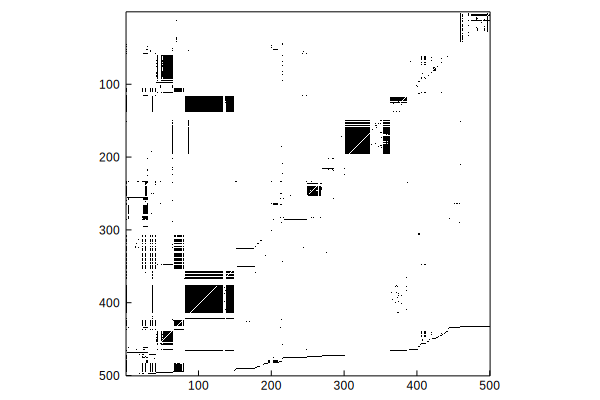

In [32]:
using Plots
spy(A)

### Q2(4)

Set the _teleportation_ parameter at $p = 0.85$. Try the following methods to solve for $\mathbf{x}$ using the `ucla.zip` data.

0. A dense linear system solver such as LU decomposition.  
0. A simple iterative linear system solver such as Jacobi or Gauss-Seidel.   
0. A dense eigen-solver.  
0. A simple iterative eigen-solver such as the power method.  

For iterative methods, you can use the [`IterativeSolvers.jl`](https://github.com/JuliaMath/IterativeSolvers.jl) package. Make sure to utilize the special structure of $\mathbf{P}$ (sparse + rank 1) to speed up the matrix-vector multiplication.

**1** Dense linear system solver -- LU decomposition.

In [153]:
function pagerank_linearsys_lu(A::AbstractMatrix, p::Float64 = 0.85)

    n = size(A, 1)
    outdegree = sum(A, 2)
    z = zeros(n)
    fill!(z, 1 / n)

    for i in 1:n
        if(outdegree[i] > 0)
            outdegree[i] = p / outdegree[i]
            z[i] = (1 - p) / n
        end
    end
    
    T = full(A') * Diagonal(vec(outdegree)) .+ z' - eye(n)
    T[1,:] = 1.0
    b = zeros(n)
    b[1] = 1.0
    return T \ b
end
pagerank_linearsys_lu(A)

500-element Array{Float64,1}:
 0.0127701 
 0.00130393
 0.00405405
 0.00398338
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00145083
 0.00141309
 ⋮         
 0.0011959 
 0.00149245
 0.0011959 
 0.00345944
 0.00211007
 0.0011959 
 0.0011959 
 0.0084935 
 0.0011959 
 0.00149103
 0.0011959 
 0.0011959 

**2** A simple iterative linear system solver - Jacobi 

To solve $(I - P^T)x = b$, Jacobi method proceeds as

$$
x^{t+1} = -D^{-1} (I - P^T)x^T + x^T + D^{-1}b 
$$

replace $P = diag(\mathbf{r})A + \mathbf{z}\mathbf{1_n}^T$, we get 
$$
x^{t+1} = D^{-1} A^T diag(\mathbf{r}) x^T + D^{-1}\mathbf{1_n}\mathbf{z}x^t - D^{-1}x^t + x^t +  D^{-1}b
$$

D is diagonal of $(I - P^T)$, and it is trivial to get its inverse.

In [121]:
function pagerank_linearsys_jacobi(A::AbstractMatrix, p::Float64 = 0.85,
        x0::Vector = ones(size(A, 1)) / size(A, 1), maxiter::Int = 100000,
        tol::Float64 = 1e-9)

    n = size(A, 1)
    outdegree = sum(A, 2)
    z = zeros(n)
    fill!(z, 1 / n)

    for i in 1:n
        if(outdegree[i] > 0)
            outdegree[i] = p / outdegree[i]
            z[i] = (1 - p) / n
        end
    end
    
    # Jacobi method, iteration
    d_inv = 1 ./ (1 - diag(A) .* outdegree - z)
    
    xnew = copy(x0)
    xold = similar(xnew)
    temp = similar(x0)
    
    for i in 1:maxiter
        copy!(xold, xnew)
        temp = xnew .* outdegree
        At_mul_B!(xnew, A, temp)
        xnew = d_inv .* (xnew + dot(xold, z) .- xold) .+ xold
        if(vecnorm(xnew - xold) < tol)
            break
        end
    end

    return abs.(xnew / sum(xnew))
end
using BenchmarkTools

pagerank_linearsys_jacobi(A)

500×1 Array{Float64,2}:
 0.0127701 
 0.00130393
 0.00405405
 0.00398338
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00145083
 0.00141309
 ⋮         
 0.0011959 
 0.00149245
 0.0011959 
 0.00345944
 0.00211007
 0.0011959 
 0.0011959 
 0.0084935 
 0.0011959 
 0.00149103
 0.0011959 
 0.0011959 

**3** A dense eigen-solver.

In [122]:
function pagerank_eig_dense(A::AbstractMatrix, p::Float64 = 0.85)

    n = size(A, 1)
    outdegree = sum(A, 2)
    z = zeros(n)
    fill!(z, 1 / n)

    for i in 1:n
        if(outdegree[i] > 0)
            outdegree[i] = p / outdegree[i]
            z[i] = (1 - p) / n
        end
    end
    
    T = eigfact!(full((Diagonal(vec(outdegree)) * A .+ z)'))
    pgrank = real(T[:vectors][:, 1])
    return abs.(pgrank / sum(pgrank))
end
pagerank_eig_dense(A)

500-element Array{Float64,1}:
 0.0127701 
 0.00130393
 0.00405405
 0.00398338
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00145083
 0.00141309
 ⋮         
 0.0011959 
 0.00149245
 0.0011959 
 0.00345944
 0.00211007
 0.0011959 
 0.0011959 
 0.0084935 
 0.0011959 
 0.00149103
 0.0011959 
 0.0011959 

**4** A simple iterative eigen-solver --- the power method.

In [125]:
function pagerank_eig_power(A::AbstractMatrix, p::Float64 = 0.85,
        x0::Vector = ones(size(A, 1)) / size(A, 1), maxiter::Int = 100000,
        tol::Float64 = 1e-9)

    n = size(A, 1)
    outdegree = sum(A, 2)
    z = zeros(n)
    fill!(z, 1 / n)

    for i in 1:n
        if(outdegree[i] > 0)
            outdegree[i] = p / outdegree[i]
            z[i] = (1 - p) / n
        end
    end
    
    #power method
    xnew = copy(x0)
    xold = similar(xnew)
    temp = similar(x0)
    
    for i in 1:maxiter
        copy!(xold, xnew)
        temp = xnew .* outdegree
        At_mul_B!(xnew, A, temp)
        xnew = xnew + dot(z, xold)
        if(vecnorm(xnew - xold) < tol)
            break
        end
    end

    return abs.(xnew / sum(xnew))
end

pagerank_eig_power(A)

500-element Array{Float64,1}:
 0.0127701 
 0.00130393
 0.00405405
 0.00398338
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00130393
 0.00145083
 0.00141309
 ⋮         
 0.0011959 
 0.00149245
 0.0011959 
 0.00345944
 0.00211007
 0.0011959 
 0.0011959 
 0.0084935 
 0.0011959 
 0.00149103
 0.0011959 
 0.0011959 

In [129]:
# benchmark four method
using BenchmarkTools
@benchmark pagerank_linearsys_lu(A)

BenchmarkTools.Trial: 
  memory estimate:  548.53 KiB
  allocs estimate:  140
  --------------
  minimum time:     602.201 μs (0.00% GC)
  median time:      676.525 μs (0.00% GC)
  mean time:        801.195 μs (9.54% GC)
  maximum time:     9.683 ms (92.16% GC)
  --------------
  samples:          6203
  evals/sample:     1

In [131]:
@benchmark pagerank_linearsys_jacobi(A)

BenchmarkTools.Trial: 
  memory estimate:  871.30 KiB
  allocs estimate:  3620
  --------------
  minimum time:     2.336 ms (0.00% GC)
  median time:      2.504 ms (0.00% GC)
  mean time:        2.751 ms (5.77% GC)
  maximum time:     8.737 ms (52.87% GC)
  --------------
  samples:          1814
  evals/sample:     1

In [132]:
@benchmark pagerank_eig_dense(A)

BenchmarkTools.Trial: 
  memory estimate:  15.66 MiB
  allocs estimate:  505
  --------------
  minimum time:     66.206 ms (0.00% GC)
  median time:      70.296 ms (4.09% GC)
  mean time:        77.046 ms (2.92% GC)
  maximum time:     119.193 ms (4.61% GC)
  --------------
  samples:          65
  evals/sample:     1

In [133]:
@benchmark pagerank_eig_power(A)

BenchmarkTools.Trial: 
  memory estimate:  548.53 KiB
  allocs estimate:  140
  --------------
  minimum time:     605.902 μs (0.00% GC)
  median time:      661.783 μs (0.00% GC)
  mean time:        790.426 μs (10.16% GC)
  maximum time:     5.533 ms (85.89% GC)
  --------------
  samples:          6289
  evals/sample:     1

### Q2(5)

List the top 20 ranked URLs you found.

In [137]:
equi_distri = pagerank_eig_power(A)
index = sortperm(equi_distri, rev = true)[1:20]
[collect(1:20) equi_distri[topidx] U[index]]

20×3 Array{Any,2}:
  1  …  "http://schema.org"                                                                     
  2     "http://www"                                                                            
  3     "http://www.ucla.edu"                                                                   
  4     "http://www.directory.ucla.edu"                                                         
  5     "http://www.universityofcalifornia.edu"                                                 
  6  …  "http://schema.org/CreativeWork"                                                        
  7     "http://schema.org/Text"                                                                
  8     "http://giveto.ucla.edu"                                                                
  9     "http://www.registrar.ucla.edu/calendar"                                                
 10     "http://www.uclalumni.net"                                                              
 11  …  "ht

### Q2(6)

As of Monday May 11 2018, there are at least 1.83 billion indexed webpages on internet according to <http://www.worldwidewebsize.com/>. Explain whether each of these methods works for the PageRank problem at this scale.

According to the webpage, there are at least 3.55 billion pages (Saturday, 26 May, 2018) on internet.

(1) A dense linear system solver such as LU decomposition cannot handle it. Because $2×(10^9)^3/3/10^{12}\approx 2.98×10^{16}s \approx 945 $ million years on a tera-flop supercomputer.

(2) Jacobi method gains over GE/LU if converges in  $O(n)$ iterations. Saving is huge for sparse A. Also, iterative methods we can allow looser convergence criteria to speed it up.

(3) Dense eigen-solver such as QR or SVD still cost $O(n^3)$ so won't work.

(4) Power method costs  $O(n)$ per iteration and converges slowly thus it is not as good as Jacobi method.
 

In [144]:
versioninfo()

Julia Version 0.6.2
Commit d386e40* (2017-12-13 18:08 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin15.6.0)
  CPU: Intel(R) Core(TM) i5-6267U CPU @ 2.90GHz
  WORD_SIZE: 64
  BLAS: libmkl_rt
  LAPACK: libmkl_rt
  LIBM: libopenlibm
  LLVM: libLLVM-3.9.1 (ORCJIT, skylake)
